# Определение надёжности стержня методом Монте-Карло (методом статистических испытаний)

In [ ]:
#утсновка библиотек
!pip3 install seaborn
!pip3 install tqdm

In [ ]:
from numpy import random, max
import seaborn
from matplotlib.pyplot import *

import pandas as pd

from tqdm import tqdm

# Задача

На стальной стержень действует растягивающая сила со средним значением $\bar F = 100$ кН. Средний предел текучести стержня $\bar R_y$ - 230 МПа. Площадь поперечного сечения стержня - 5.36 см2

Если известны стандартные отклонения нагрузки F - 10 кН и предела текучести $R_y$ - 10 МПа определить запас несущей способности и вероятность безотказной работы стержня.

In [ ]:
# определим функцию вычисляющую резерв несущей способности

def g_func(F, Ry, A):
    """ F:  сила в кН растягивающая стержень
    Ry - предел текучести стержня в МПа
    A - площадь поперечного сечения стержня в см2
    return: резерв несущей способности в кН
    """
    
    return Ry*A/10 - F

In [ ]:
# пример вычисления резерва несущей способности
g_func(100, 230, 5.36)

## Статистические испытания

Рассмотрим другой, не аналитический, способ решения задач, где фигурируют случайные величины.

Будем *моделировать* задачу. 

1. Предположим, что случаные велечина F и Ry подчиняются нормальному закону распределения. Эксперименты показывают, что для прочности материалов это справедливо. Предположим также, что постоянная нагрузка F тоже имеет нормальное распределение. 

1. Теперь будем с помошью генератора случайных чисел создавать значения для F и Ry. Для каждой пары сгенерированных значений F и Ry будем просто вычислять резерв несущей способности. 
Проделаем так N раз, сгенерировав N значений случайных величин и вычислив N значений резерва несущей способности. Т.е. проведём N статистических испытаний. 

1. Таким образом мы как бы перебираем все возможные значения нагрузки и сопротивления, которые могут возникнуть в этой расчётной схеме. Чтоит отметить, что значения для случайных величин выбирается в соответствии с их параметрами (среднее и стандартное отклонение), т.е. эти числа хоть и произвольны но в ограниченом диапазоне.

1. подсчитаем сколько раз из N, резерв несущей способности g оказался больше нуля
1. определим вероятность неразрушения по формуле $ P = \frac{M}{N} $, где M - число раз когда g > 0

In [ ]:
# средние значения случайных величин
Fav = 100  # кН
Ryav = 230  # МПа


# стандартные отклонения случайных величин
SF = 10  # кН
SRy = 10  # МПа

# постоянные величины задачи
A = 5.36  # см2


# количество статистических испытаний
N = 1000

# счётчик: число успешных испытаний (g>0)
M = 0

experiments = pd.DataFrame(columns=["F", "Ry", "g"])

# цикл повторяющий статистические испытания
for i in tqdm(range(N)):
    
    # генерирование нормально распределённых случайных величин
    # loc - математическое ожидание
    # scale - стандартное отклонение
    F = random.normal(loc=Fav, scale=SF)
    Ry = random.normal(loc=Ryav, scale=SRy)
    
    g = g_func(F, Ry, A)
    
    experiments.loc[i] = F, Ry, g 
    
    if g > 0:
        M = M + 1
    
# определение надёжности
P = M / N

# для примера напечатаем данные 20 случайных статистических испытаний
print("Некоторые статистические испытания")
print( experiments.sample(30) )

print()
print(f"Надёжность: {P:.5f}")

Код в ячейке выше нужно запустить несколько раз, чтобы убедится в устойчивости ответа. Если от запуска к запуску ответ сильно меняется (в третьем знаке или раньше), то его считаем неустойчивым.

В этом случае нужно увеличить число испытаний N. Рекомендуется увеличивать на порядок или меньше.

Можно выбрать и большое число статистических испытаний, чтобы ответ не менялся и в четвёртом знаке после запятой, но проведения такого числа испытаний это может потребовать много времени.


**Примечание**

Для определения N при котором ответ достаточно устойчив можно сделать из верхней ячейки отдельную функцию с параметром N. Далее перебором, постепенно увеличивая N найти определить момент, когда ответ перестаёт сильно изменятся

### Визуализация

In [ ]:
figure(figsize=(10,6))
title("Нагрузочный эффект и сопротивление")
seaborn.distplot( experiments['Ry']*A/10, label ="сопротивление R" )
seaborn.distplot( experiments['F'], label="нагрузочный эффект L" )
xlabel("МПа")
ylabel("Плотность вероятности")
grid()
legend(loc='best')

**Пример** графиков нагрузочного эффекта и сопротивления.

Для системы с надёжностью больше 0.5 распределение нагрузочного эффекта должно быть левее нагрузочного эффекта. Т.е. среднее сопротивление должно быть больше среднего нагрузочного эффекта.

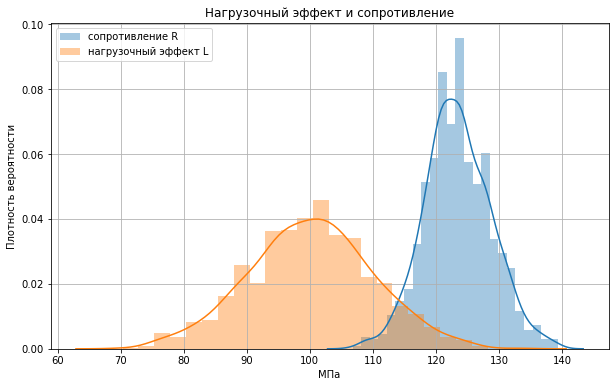